In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import os
import seaborn as sns
from scipy import stats
from simulation import *

In [2]:
# np.random.seed(123)

### Generate True Parameters For each Participant on Hierarchical level

In [4]:
# Number of simulation
simNumber = 1

# Set mean and std of unkown parameters
alphaAct_mu = np.round(np.random.rand(2, 2), 2)
alphaAct_sd = np.round(np.random.rand(2, 2), 2)

alphaClr_mu = np.round(np.random.rand(2, 2), 2)
alphaClr_sd = np.round(np.random.rand(2, 2), 2)

weghtAct_mu = np.round(np.random.rand(2, 2), 2)
weghtAct_sd = np.round(np.random.rand(2, 2), 2)

beta_mu = 5*np.round(np.random.rand(2, 2), 2)
beta_sd = 5*np.round(np.random.rand(2, 2), 2)

trueParam(alphaAct_mu=alphaAct_mu, alphaAct_sd=alphaAct_sd,
          alphaClr_mu=alphaClr_mu, alphaClr_sd=alphaClr_sd,
          weghtAct_mu=weghtAct_mu, weghtAct_sd=weghtAct_sd,
          beta_mu=beta_mu, beta_sd=beta_sd,
          simNumber=simNumber)

In [8]:
# Fist type of learning in sesion 1 and run 1   
data = sim
subName = 'simulation'
firstActOrClr = np.unique(data[0:1]['stimActFirst'])

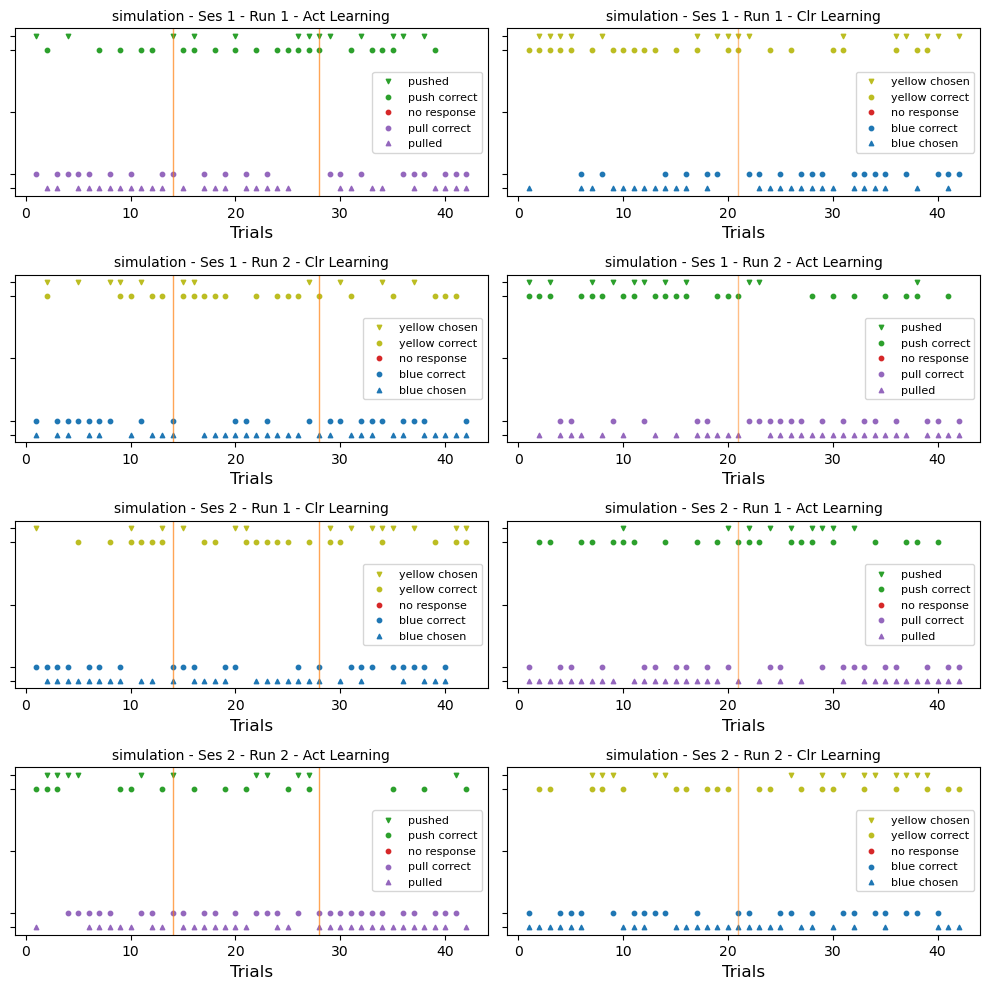

In [9]:
# Figure of behavioral data in two column and four rows
fig = plt.figure(figsize=(10, 10), tight_layout=True)
rows = 4
columns = 2
y = [3.2 ,3, 2.1 , 1.2, 1] 
markers = ['v', 'o', 'o' , 'o', '^']
colorsAct =['#2ca02c','#2ca02c', '#d62728', '#9467bd', '#9467bd']
colorsClr =['#bcbd22','#bcbd22', '#d62728', '#1f77b4', '#1f77b4']

titlesAct = [subName + ' - Ses 1 - Run 1 - Act Learning', 
             subName + ' - Ses 1 - Run 1 - Clr Learning',
             subName + ' - Ses 1 - Run 2 - Clr Learning',
             subName + ' - Ses 1 - Run 2 - Act Learning',
             subName + ' - Ses 2 - Run 1 - Clr Learning', 
             subName + ' - Ses 2 - Run 1 - Act Learning',
             subName + ' - Ses 2 - Run 2 - Act Learning',
             subName + ' - Ses 2 - Run 2 - Clr Learning']

titlesClr = [subName + ' - Ses 1 - Run 1 - Clr Learning', 
             subName + ' - Ses 1 - Run 1 - Act Learning',
             subName + ' - Ses 1 - Run 2 - Act Learning',
             subName + ' - Ses 1 - Run 2 - Clr Learning',
             subName + ' - Ses 2 - Run 1 - Act Learning', 
             subName + ' - Ses 2 - Run 1 - Clr Learning',
             subName + ' - Ses 2 - Run 2 - Clr Learning',
             subName + ' - Ses 2 - Run 2 - Act Learning']

orderAct = ['Act', 'Stim', 'Stim', 'Act', 'Stim', 'Act', 'Act', 'Stim']
orderClr = ['Stim', 'Act', 'Act', 'Stim', 'Act', 'Stim', 'Stim', 'Act']


if firstActOrClr == 'Act':
    titles = titlesAct
    order = orderAct
elif firstActOrClr=='Stim':
    titles = titlesClr
    order = orderClr
    
idx = 0
for s in range(1, 3):
    for r in range(1, 3):
        for b in range(1, 3):
            fig.add_subplot(rows, columns, idx+1) 
            #plt.subplots_adjust(hspace=1, wspace=1.)
            if order[idx] == 'Act':
                dataCondAct = data[(data.session==s) & (data.run==r) & (data.block==order[idx])]

                resAct = dataCondAct['pushed'].to_numpy().astype(int)
                pushed = np.where(resAct==1)[0] + 1
                pulled = np.where(resAct==0)[0] + 1
                noRes  = np.where(resAct < 0)[0] + 1

                corrAct= dataCondAct['pushCorrect']
                pushCorr = np.where(corrAct==1)[0] + 1
                pulledCorr = np.where(corrAct==0)[0] + 1


                dicDataAct = ({'label': ['pushed', 'push correct', 'no response', 'pull correct', 'pulled'],
                            'choise': [pushed, pushCorr, noRes, pulledCorr, pulled]})
                dfPlotAct = pd.DataFrame(dicDataAct)
                
                #create a list of y coordinates for every x coordinate
                for i in range(len(dfPlotAct)):
                    plt.scatter(dfPlotAct.choise[i],[y[i] for j in range(len(dfPlotAct.choise[i]))], 
                                s=10, c=colorsAct[i], marker=markers[i])

                plt.yticks(y,[]) #show the empy y axis label
                plt.xlabel('Trials', fontsize=12)
                plt.title(titles[idx], fontsize=10)    
                plt.legend(dfPlotAct.label, fontsize=8)      
            
            elif order[idx] == 'Stim':
                dataCondClr = data[(data.session==s) & (data.run==r) & (data.block==order[idx])]
                
                resClr = dataCondClr['yellowChosen'].to_numpy().astype(int)
                yellChosen = np.where(resClr==1)[0] + 1
                blueChosen = np.where(resClr==0)[0] + 1
                noRes  = np.where(resClr < 0)[0] + 1

                corrClr= dataCondClr['yellowCorrect']
                yellCorr = np.where(corrClr==1)[0] + 1
                blueCorr = np.where(corrClr==0)[0] + 1


                dicDataClr = ({'label': ['yellow chosen', 'yellow correct', 'no response', 'blue correct', 'blue chosen'],
                            'choise': [yellChosen, yellCorr, noRes, blueCorr, blueChosen]})
                dfPlotClr = pd.DataFrame(dicDataClr)         
                    
                #create a list of y coordinates for every x coordinate
                for i in range(len(dfPlotClr)):
                    plt.scatter(dfPlotClr.choise[i],[y[i] for j in range(len(dfPlotClr.choise[i]))], 
                                s=10, c=colorsClr[i], marker=markers[i])


                plt.yticks(y,[]) #show the empy y axis label
                plt.xlabel('Trials', fontsize=12) 
                plt.title(titles[idx], fontsize=10)   
                plt.legend(dfPlotClr.label, fontsize=8)          

            if idx%2==1:
                plt.axvline(x = 21, color='#ff7f0e', linewidth=1, alpha=.5)
            else:
                plt.axvline(x = 14, color='#ff7f0e', linewidth=1, alpha=.7)
                plt.axvline(x = 28, color='#ff7f0e', linewidth=1, alpha=.7)
                    
            idx += 1